In [71]:
import os
import requests
import fitz
import torch
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
import random
from spacy.lang.en import English
import re
from sentence_transformers import SentenceTransformer
from PIL import Image
from IPython.display import display
import textwrap
import ipywidgets as widgets
import io

In [31]:
# Check for GPU availability
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
pdf_path = 'local_document.pdf'

if os.path.exists(pdf_path):
    print("File already exists.")
else:
    print('File not found, downloading...')
    file_url = 'https://pressbooks.oer.hawaii.edu/humannutrition2/open/download?type=pdf'
    response = requests.get(file_url)
    if response.status_code == 200:
        with open(pdf_path, 'wb') as file:
            file.write(response.content)
        print(f'File downloaded and saved as {pdf_path}')
    else:
        print(f'Error downloading file. Status code: {response.status_code}')

File already exists.


In [4]:
def text_formatter(text):
    formatted_text = text.replace('\n', ' ').strip()
    return formatted_text

In [5]:
def pdf_to_page(pdf_path):
    pdf = fitz.open(pdf_path)
    pdf_to_page = []

    for page_no, page_content in enumerate(pdf.pages()):
        page_text = page_content.get_text()
        page_text = text_formatter(page_text)
        page_info = {'page_no': page_no,
                    'character_count': len(page_text),
                    'word_count': len(page_text.split(' ')),
                    'sentence_count': len(page_text.split('. ')),
                    'token_count': len(page_text)/4,
                    'text': page_text,
                    'sentences': page_text.split('. ')}
        
        pdf_to_page.append(page_info)
    
    return pdf_to_page

pages = pdf_to_page(pdf_path)

In [6]:
max_sentence_size = 10
def split_list(pages_list, max_sentence_size):
    for page in pages_list:
        sentence_grouped = []
        for i in range(0, page['sentence_count'], max_sentence_size):
            sentence_group = ''.join(page['sentences'][i: i+max_sentence_size])
            sentence_grouped.append(sentence_group)
        page['sentence_grouped'] = sentence_grouped
        page['sentence_group_count'] = len(sentence_grouped)

    return pages_list

updated_pages = split_list(pages, max_sentence_size)

In [7]:
random.sample(updated_pages, 2)

[{'page_no': 320,
  'character_count': 1894,
  'word_count': 298,
  'sentence_count': 13,
  'token_count': 473.5,
  'text': 'Benefits of Sugar Substitutes  Consuming foods and beverages containing sugar substitutes may  benefit health by reducing the consumption of simple sugars, which  are higher in calories, cause tooth decay, and are potentially linked  to chronic disease. Artificial sweeteners are basically non-nutrients  though not all are completely calorie-free. However, because they  are so intense in sweetness they are added in very small amounts  to foods and beverages. Artificial sweeteners and sugar alcohols are  not “fermentable sugars” and therefore they do not cause tooth  decay. Chewing gum with artificial sweeteners is the only proven  way that artificial sweeteners promote oral health. The American  Dental Association (ADA) allows manufacturers of chewing gum to  label packages with an ADA seal if they have convincing scientific  evidence demonstrating their product e

# Divide text into sentences using spacy

In [8]:
def sentencing_using_spacy(pages_list):
    nlp = English()
    nlp.add_pipe('sentencizer')

    for page in pages_list:
        sentences = [str(sentence) for sentence in nlp(page['text']).sents]
        page['sentences_spacy'] = sentences
        page['sentences_spacy_count'] = len(sentences)
    
    return pages_list

updated_pages_spacy = sentencing_using_spacy(updated_pages)

In [9]:
random.sample(updated_pages_spacy, 2)

[{'page_no': 42,
  'character_count': 93,
  'word_count': 21,
  'sentence_count': 3,
  'token_count': 23.25,
  'text': 'PART I  CHAPTER 1. BASIC  CONCEPTS IN NUTRITION  Chapter 1. Basic Concepts in Nutrition  |  1',
  'sentences': ['PART I  CHAPTER 1',
   'BASIC  CONCEPTS IN NUTRITION  Chapter 1',
   'Basic Concepts in Nutrition  |  1'],
  'sentence_grouped': ['PART I  CHAPTER 1BASIC  CONCEPTS IN NUTRITION  Chapter 1Basic Concepts in Nutrition  |  1'],
  'sentence_group_count': 1,
  'sentences_spacy': ['PART I  CHAPTER 1.',
   'BASIC  CONCEPTS IN NUTRITION  Chapter 1.',
   'Basic Concepts in Nutrition  |  1'],
  'sentences_spacy_count': 3},
 {'page_no': 602,
  'character_count': 875,
  'word_count': 152,
  'sentence_count': 8,
  'token_count': 218.75,
  'text': 'Age Group  RDA Males and Females mg/day  Infants (0–6 months)  0.2 *  Infants (7–12 months)  0.3  Children (1–3 years)  0.5  Children (4–8 years)  0.6  Children (9–13 years)  0.9  Adolescents (14–18 years)  1.2 (males), 1.0 (fe

# Chunking

In [10]:
def sentences_list(pages_list, max_sentence_size):
    sentences_list = []
    for page in pages_list:
        for i in range(0, page['sentences_spacy_count'], max_sentence_size):
            sentence_group = ''.join(page['sentences_spacy'][i: i+max_sentence_size])
            sentence_group = sentence_group.replace('  ', ' ').strip()
            sentence_group = re.sub(r'\.([A-Z])', r'. \1', sentence_group)

            sentence = {
                'page_no': page['page_no'],
                'sentences': sentence_group,
                'token_count': len(sentence_group) / 4
            }
            sentences_list.append(sentence)

    return sentences_list

In [11]:
sentences_grouped = sentences_list(updated_pages_spacy, max_sentence_size)

In [12]:
random.sample(sentences_grouped, 1)

[{'page_no': 97,
  'sentences': '• Explain the anatomy and physiology of the digestive system and other supporting organ systems • Describe the relationship between diet and each of the organ systems • Describe the process of calculating Body Mass Index (BMI) The Native Hawaiians believed there was a strong connection between health and food. Around the world, other cultures had similar views of food and its relationship with health. A famous quote by the Greek physician Hippocrates over two thousand years ago, “Let food be thy medicine and medicine be thy food” bear much relevance on our food choices and their connection to our health. Today, the scientific community echoes Hippocrates’ statement as it recognizes some foods as functional foods. The Academy of Nutrition and Dietetics defines functional foods as “whole foods and fortified, enriched, or enhanced foods that have a potentially beneficial effect on health when consumed as part of a varied diet on a regular basis, at effecti

In [13]:
df = pd.DataFrame(sentences_grouped)
df.describe()

,page_no,token_count
count,1843.000000,1843.000000
mean,624.381443,183.524688
std,347.788670,111.877665
min,0.000000,3.000000
25%,321.500000,78.750000
50%,627.000000,186.250000
75%,931.000000,279.500000
max,1207.000000,457.500000


In [14]:
df.head(5)

,page_no,sentences,token_count
0,0,Human Nutrition: 2020 Edition,7.25
1,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,77.00
2,3,Human Nutrition: 2020 Edition by University of...,52.50
3,4,Contents Preface University of Hawai‘i at Māno...,191.50
4,5,Lifestyles and Nutrition University of Hawai‘i...,235.25


In [15]:
min_token_length = 30

sentences_filtered = df[df['token_count'] >= min_token_length]

In [16]:
sentences_filtered

,page_no,sentences,token_count
1,2,Human Nutrition: 2020 Edition UNIVERSITY OF HA...,77.00
2,3,Human Nutrition: 2020 Edition by University of...,52.50
3,4,Contents Preface University of Hawai‘i at Māno...,191.50
4,5,Lifestyles and Nutrition University of Hawai‘i...,235.25
5,6,The Cardiovascular System University of Hawai‘...,249.50
...,...,...,...
1838,1205,Flashcard Images Note: Most images in the flas...,326.00
1839,1205,Hazard Analysis Critical Control Points reused...,93.50
1840,1206,ShareAlike 11. Organs reused “Pancreas Organ A...,321.25
1841,1206,Sucrose reused “Figure 03 02 05” by OpenStax B...,102.50


# Embedding

In [32]:
embedding_model = SentenceTransformer('all-mpnet-base-v2', device=device)

In [18]:
for _, sentence_dict in sentences_filtered.iterrows():
    sentence = sentence_dict['sentences']
    sentence_dict['embedding'] = embedding_model.encode(sentence)

Comparison when embedding with batches

In [19]:
text_chunks = [sentence_dict["sentences"] for _, sentence_dict in sentences_filtered.iterrows()]

In [33]:
# Embed all texts in batches
text_chunk_embeddings = embedding_model.encode(text_chunks,
                                               batch_size=16,
                                               convert_to_tensor=True)

text_chunk_embeddings

tensor([[ 0.0674,  0.0902, -0.0051,  ..., -0.0221, -0.0232,  0.0126],
        [ 0.0552,  0.0592, -0.0166,  ..., -0.0120, -0.0103,  0.0227],
        [ 0.0280,  0.0340, -0.0206,  ..., -0.0054,  0.0213,  0.0313],
        ...,
        [ 0.0771,  0.0098, -0.0122,  ..., -0.0409, -0.0752, -0.0241],
        [ 0.1030, -0.0165,  0.0083,  ..., -0.0574, -0.0283, -0.0295],
        [ 0.0864, -0.0125, -0.0113,  ..., -0.0522, -0.0337, -0.0299]],
       device='cuda:0')

In [21]:
text_chunk_embeddings.shape

torch.Size([1680, 768])

# Query

In [48]:
query = 'Macronutrients functions'

query_embedded = torch.tensor(embedding_model.encode(query)).to(device)
query_embedded, query_embedded.shape

(tensor([ 3.6350e-02, -5.8203e-02, -1.8262e-02,  1.4228e-02,  1.3136e-02,
          4.3278e-02, -3.3172e-02, -1.1831e-02, -4.3201e-02, -6.8741e-02,
         -1.8463e-02, -1.5240e-02,  1.9626e-02,  4.7535e-02,  2.7343e-02,
         -7.1382e-03,  1.0865e-02, -2.5707e-02, -7.7592e-02, -5.8880e-03,
         -3.2791e-02,  2.0640e-02,  1.3843e-02, -6.2041e-03, -2.2706e-02,
          3.9274e-02,  4.0431e-02,  5.1309e-03,  1.1578e-02, -1.1135e-02,
         -1.9891e-02, -1.8691e-03, -4.9330e-02, -8.7934e-02,  1.5259e-06,
         -3.3809e-02, -4.7408e-02,  1.7066e-02, -7.5259e-02,  3.4821e-02,
          2.9377e-02, -3.2112e-02, -1.6509e-02,  7.3573e-03,  4.6359e-02,
         -4.1220e-03,  1.4522e-02,  3.7193e-04, -6.3193e-02,  1.9782e-02,
          2.9439e-02,  4.7811e-02,  1.6230e-02, -1.6853e-02,  2.3415e-02,
          4.1553e-02,  8.8754e-03,  2.3375e-02, -3.9122e-02,  3.5091e-02,
          6.1852e-02,  3.5322e-02, -1.1847e-03, -8.1968e-03,  4.3451e-02,
          5.5786e-02, -2.3311e-02, -3.

In [82]:
# Find best match between text embeddings and query embedding
dot_products = text_chunk_embeddings @ query_embedded

top_values, top_indices = torch.topk(dot_products, k=5)
top_values, top_indices

(tensor([0.6926, 0.6738, 0.6646, 0.6536, 0.6473], device='cuda:0'),
 tensor([42, 47, 41, 51, 46], device='cuda:0'))

Print the best matching paragraphs

In [120]:
top_matching_sentences = [{'Score': float(value), 'Paragraph': sentences_filtered.iloc[int(index), df.columns.get_loc('sentences')]} for value, index in zip(top_values, top_indices)]

for sentence in top_matching_sentences:
    score = sentence['Score']
    paragraph = sentence['Paragraph']
    
    # Wrap the paragraph text
    formatted_paragraph = textwrap.fill(paragraph, width=200)
    
    print(f"Score: {score:.5f}")
    print(formatted_paragraph)
    print("-" * 200)

Score: 0.69258
Macronutrients Nutrients that are needed in large amounts are called macronutrients. There are three classes of macronutrients: carbohydrates, lipids, and proteins. These can be metabolically
processed into cellular energy. The energy from macronutrients comes from their chemical bonds. This chemical energy is converted into cellular energy that is then utilized to perform work, allowing
our bodies to conduct their basic functions. A unit of measurement of food energy is the calorie. On nutrition food labels the amount given for “calories” is actually equivalent to each calorie
multiplied by one thousand. A kilocalorie (one thousand calories, denoted with a small “c”) is synonymous with the “Calorie” (with a capital “C”) on nutrition food labels. Water is also a
macronutrient in the sense that you require a large amount of it, but unlike the other macronutrients, it does not yield calories. Carbohydrates Carbohydrates are molecules composed of carbon,
hydrogen, and oxyge

Display the best matching pages

In [127]:
page_nos = [int(sentences_filtered.iloc[int(idx), df.columns.get_loc('page_no')]) for idx in top_indices]
page_nos

[46, 49, 45, 52, 48]

In [128]:
pdf_file = fitz.open(pdf_path)
page_images = []

for page_no in page_nos:
    page = pdf_file[page_no]
    pix = page.get_pixmap() # Get pixmap of the page
    page_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples) # Convert pixmap to PIL Image
    
    # Convert the PIL Image to bytes
    img_bytes = io.BytesIO()
    page_image.save(img_bytes, format='png')
    img_bytes = img_bytes.getvalue()
    
    # Create the ipywidgets.Image widget with the memoryview
    page_images.append(widgets.Image(value=memoryview(img_bytes)))

# Display the page images side by side using an HBox container
display(widgets.HBox(page_images))

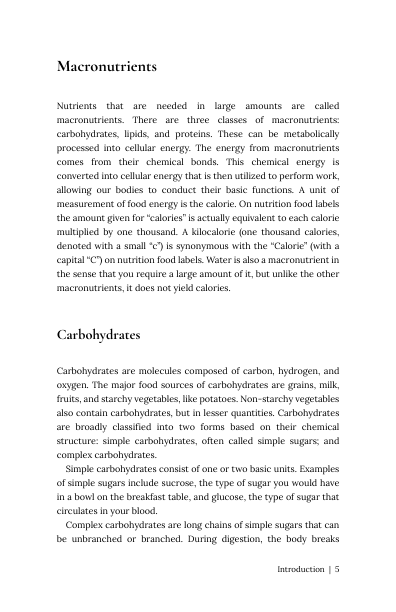

In [129]:
page = pdf_file[page_nos[0]]
pix = page.get_pixmap()
page_image = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

display(page_image)